In [1]:
%matplotlib inline

## Motivations
https://pytorch.org/tutorials/beginner/colab

https://github.com/Spandan-Madan/Pytorch_fine_tuning_Tutorial/blob/master/main_fine_tuning.py#L252

For testing robustness have a look at the following:

https://github.com/szegedai/robust-stitching

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
#import torchaudio
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

## Load and transform data

In [3]:
transform = {
    'train': transforms.Compose([transforms.Resize(255),
                                 transforms.RandomRotation(30),
                                 transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.5, 0.5, 0.5],
                                                      [0.5, 0.5, 0.5])]),
    'val': transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])
}
data_dir = '../data/hymenoptera_data/'
#dataset = datasets.ImageFolder(data_dir, transform=transform['train'])
dataset = {}
dataloader = {}
for x in ['train', 'val']:
    dataset[x] = datasets.ImageFolder(os.path.join(data_dir, x), transform=transform[x])
    dataloader[x] = torch.utils.data.DataLoader(dataset[x], batch_size=32, shuffle=True)

In [4]:
# Lets see what dataset looks like
dataset

{'train': Dataset ImageFolder
     Number of datapoints: 246
     Root location: ../data/hymenoptera_data/train
     StandardTransform
 Transform: Compose(
                Resize(size=255, interpolation=bilinear, max_size=None, antialias=warn)
                RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
            ),
 'val': Dataset ImageFolder
     Number of datapoints: 153
     Root location: ../data/hymenoptera_data/val
     StandardTransform
 Transform: Compose(
                Resize(size=255, interpolation=bilinear, max_size=None, antialias=warn)
                CenterCrop(size=(224, 224))
                ToTensor()
            )}

In [5]:
# Need to investigate these sequential transforms

# transform = torch.nn.Sequential(
#     transforms.CenterCrop(10),
#     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
#     transforms.ToTensor()
# )
# scripted_transform = torch.jit.script(transform)
# dataset2 = datasets.ImageFolder('data', transform=transform)

In [6]:
#dataloader = torch.utils.data.DataLoader(dataset['train'], batch_size=32, shuffle=True)

In [7]:
dataloader

{'train': <torch.utils.data.dataloader.DataLoader at 0x1128d42d0>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x11dd48a50>}

In [8]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.5, 0.5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


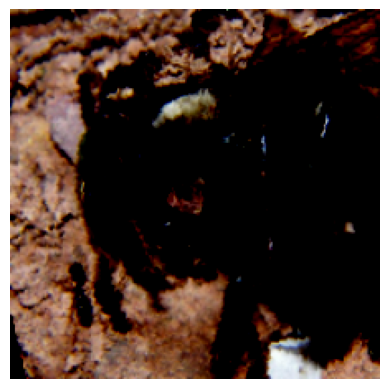

In [10]:
images, labels = next(iter(dataloader['train']))
imshow(images[0], normalize=False);

In [11]:
# Data augmentation example
train_transforms = transforms.Compose([transforms.Resize(255),
                                       transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5], 
                                                            [0.5, 0.5, 0.5])])
dataset_aug = datasets.ImageFolder(data_dir, transform=train_transforms)

In [12]:
dataset_aug

Dataset ImageFolder
    Number of datapoints: 399
    Root location: ../data/hymenoptera_data/
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=bilinear, max_size=None, antialias=warn)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

In [13]:
dataloader_aug = torch.utils.data.DataLoader(dataset_aug, batch_size=32, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


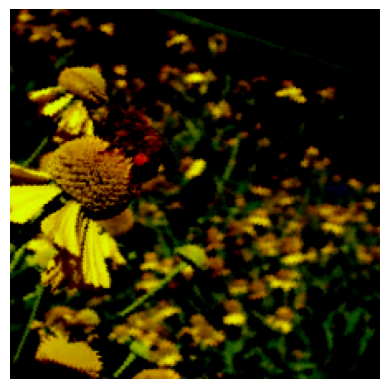

In [14]:
images, labels = next(iter(dataloader_aug))
imshow(images[0], normalize=False);

In [15]:
#def train_model(model, loss_function, optimizer, dataloader):
def train_model(dataloader, loss_function, model, optimizer, scheduler, num_epochs=5):
    for epoch in range(num_epochs):
        print('Epoch number: {}'.format(epoch))
        for learning_mode in ['train', 'val']:
            if learning_mode == 'train':
                model.train()
            else:
                model.eval()
                
            for i, data in enumerate(dataloader[learning_mode]):
                images, labels = data
                #print(labels[0], np.shape(images))
                optimizer.zero_grad()
                outputs = model(images)
                loss = loss_function(outputs, labels)
                if learning_mode == 'train':
                    loss.backward()
                    optimizer.step()
                # outputs = model(images)
                _, preds = torch.max(outputs, 1)
                print(learning_mode+' loss:', loss.item())
                #print(loss_function(outputs, labels), labels[0], preds)
        
                #imshow(images[0], normalize=False)
        scheduler.step()

In [16]:
# Select loss function
loss_function = nn.CrossEntropyLoss()
#loss_function = nn.SoftMarginLoss()

# Load a pre-trained model
model = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)
# Select Optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [34]:
optimizer.zero_grad()
for group in optimizer.param_groups:
    for p in group["params"]:
        print(len(p))

64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
2
2


## SGD optimizer

In [14]:
# Select loss function
loss_function = nn.CrossEntropyLoss()
#loss_function = nn.SoftMarginLoss()

# Load a pre-trained model
model = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)
# Select Optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# var1 = 0.1
# var2 = 0.01
# optimizer = optim.Adam([var1, var2], lr=0.0001)

scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

train_model(dataloader=dataloader, loss_function=loss_function, model=model, optimizer=optimizer, scheduler=scheduler)

Epoch number: 0
train loss: 0.7930099964141846
train loss: 0.7622217535972595
train loss: 0.7150488495826721
train loss: 0.715829610824585
train loss: 0.6773821115493774
train loss: 0.660115659236908
train loss: 0.6887292861938477
train loss: 0.5960307717323303
val loss: 0.5893791913986206
val loss: 0.5229277014732361
val loss: 0.5618584752082825
val loss: 0.6076122522354126
val loss: 0.5777778029441833
Epoch number: 1
train loss: 0.5372008085250854
train loss: 0.5402486324310303
train loss: 0.5870249271392822
train loss: 0.4814426600933075
train loss: 0.460015207529068
train loss: 0.380684494972229
train loss: 0.49094316363334656
train loss: 0.5188064575195312
val loss: 0.4249478280544281
val loss: 0.34891268610954285
val loss: 0.4626134932041168
val loss: 0.43687301874160767
val loss: 0.2954336702823639
Epoch number: 2
train loss: 0.47444820404052734
train loss: 0.39458978176116943
train loss: 0.482052743434906
train loss: 0.43061569333076477
train loss: 0.29492634534835815
train los

## Using Adam

In [15]:
# Select loss function
loss_function = nn.CrossEntropyLoss()
#loss_function = nn.SoftMarginLoss()

# Load a pre-trained model
model_adam = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_adam.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_adam.fc = nn.Linear(num_ftrs, 2)

model_adam = model_adam.to(device)
# Select Optimizer
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# var1 = 0.1
# var2 = 0.01
optimizer = optim.Adam(model_adam.parameters(), lr=0.0001)

train_model(dataloader=dataloader, loss_function=loss_function, model=model_adam, optimizer=optimizer, scheduler=scheduler)

Epoch number: 0
train loss: 0.8357402682304382
train loss: 0.6367332339286804
train loss: 0.63161301612854
train loss: 0.3627673387527466
train loss: 0.3557596504688263
train loss: 0.3129470646381378
train loss: 0.36070558428764343
train loss: 0.18960870802402496
val loss: 0.34481915831565857
val loss: 0.29065579175949097
val loss: 0.4098426103591919
val loss: 0.245467409491539
val loss: 0.2579442858695984
Epoch number: 1
train loss: 0.218491330742836
train loss: 0.2862953841686249
train loss: 0.26114389300346375
train loss: 0.20658054947853088
train loss: 0.1970571130514145
train loss: 0.12187281996011734
train loss: 0.10376274585723877
train loss: 0.13798025250434875
val loss: 0.3289324641227722
val loss: 0.17598117887973785
val loss: 0.20763666927814484
val loss: 0.2149675041437149
val loss: 0.5535846948623657
Epoch number: 2
train loss: 0.07734551280736923
train loss: 0.22489750385284424
train loss: 0.22617295384407043
train loss: 0.13051587343215942
train loss: 0.20377080142498016

In [16]:
model_adam.state_dict

<bound method Module.state_dict of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [17]:
params = list(model.parameters())
print(len(params))
print("Parameters for layer 1 {}, layer 2 {}, and layer 3 {}".format(params[0].size(), params[1].size(), params[2].size()))

62
Parameters for layer 1 torch.Size([64, 3, 7, 7]), layer 2 torch.Size([64]), and layer 3 torch.Size([64])


In [18]:
torch.norm(params[0])

tensor(12.5795, grad_fn=<LinalgVectorNormBackward0>)

In [19]:
params_adam = list(model_adam.parameters())
print(len(params_adam))
print("Parameters for layer 1 {}, layer 2 {}, and layer 3 {}".format(params_adam[0].size(), params_adam[1].size(), params_adam[2].size()))

62
Parameters for layer 1 torch.Size([64, 3, 7, 7]), layer 2 torch.Size([64]), and layer 3 torch.Size([64])


In [20]:
torch.norm(params[0] - params_adam[0])/torch.norm(params[0])

tensor(0.0059, grad_fn=<DivBackward0>)

In [21]:
model_resnet = models.resnet18(weights='IMAGENET1K_V1')

In [22]:
params_res = list(model_resnet.parameters())
print(len(params_res))
print("Parameters for layer 1 {}, layer 2 {}, and layer 3 {}".format(params_res[0].size(), params_res[1].size(), params_res[2].size()))

62
Parameters for layer 1 torch.Size([64, 3, 7, 7]), layer 2 torch.Size([64]), and layer 3 torch.Size([64])


In [23]:
print("diff between layer 1 of ResNet and SGD is {} and Adam is {}".format(torch.norm(params_res[0] - params[0])/torch.norm(params_res[0]), torch.norm(params_res[0] - params_adam[0])/torch.norm(params_res[0])))

diff between layer 1 of ResNet and SGD is 0.004152098670601845 and Adam is 0.004740229807794094


In [24]:
params_adam[2]

Parameter containing:
tensor([ 2.3042e-01,  2.5407e-01, -1.0543e-06, -6.6395e-01, -1.6571e-08,
         1.6252e-01,  4.5405e-01, -4.3020e-07,  3.0031e-01, -8.0052e-06,
         3.4987e-01,  3.1210e-01, -2.4880e-01, -3.4749e-05,  1.0772e-01,
         2.1945e-01,  3.8162e-01, -5.2940e-01, -6.2803e-01,  5.7174e-01,
         2.9988e-01,  5.8467e-01,  4.8129e-01,  3.2887e-01,  1.9641e-01,
         1.9418e-01,  1.5274e-01,  8.5351e-02,  5.1290e-01,  1.4263e-02,
         1.6600e-01,  3.3293e-01,  2.4851e-01,  4.4391e-01, -2.8070e-01,
        -2.0748e-02, -2.4507e-07,  3.2005e-01, -4.9152e-08,  2.3733e-01,
         2.3288e-01,  3.1531e-01,  4.2791e-01,  2.9473e-01,  2.6445e-01,
         6.7647e-01,  4.2830e-01,  3.4688e-01, -8.6909e-08,  2.4663e-01,
         3.0398e-01,  6.1615e-01,  3.9893e-01,  3.3112e-01, -4.1221e-01,
         3.7767e-01,  1.8015e-01,  2.5684e-01, -4.4891e-01,  2.1227e-01,
         5.6945e-01,  5.7223e-01, -4.0364e-01,  2.3466e-01],
       requires_grad=True)

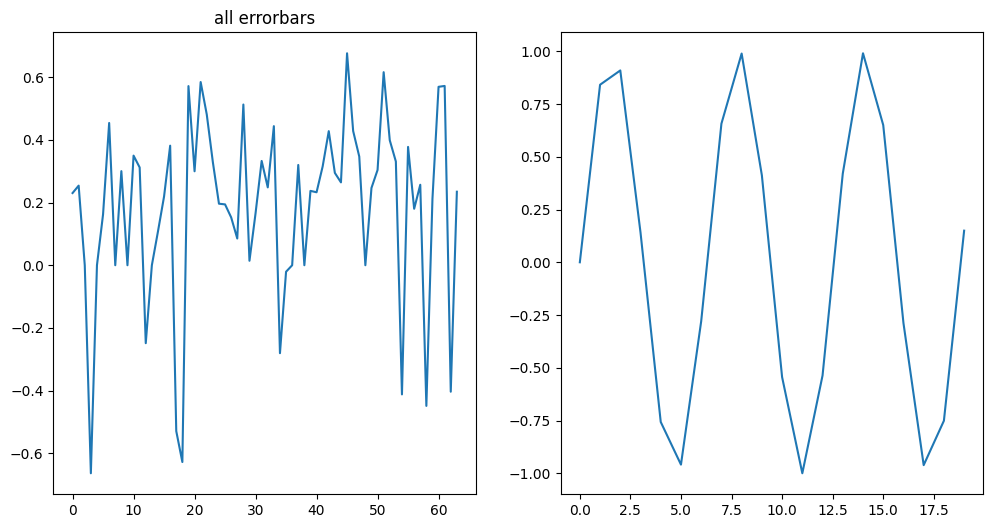

In [42]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, sharex=False,
                                    figsize=(12, 6))

ax0.set_title('all errorbars')
ax0.plot(params_adam[2].detach().cpu().numpy())
ax1.plot(np.sin(range(20)))

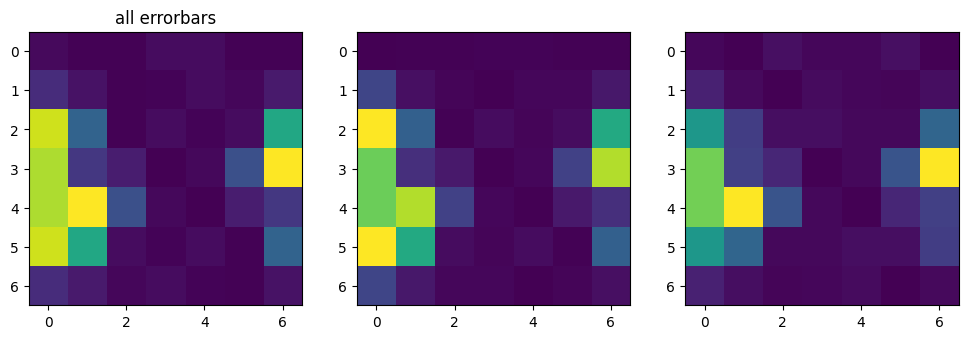

In [49]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3,figsize=(12, 6))

ax0.set_title('all errorbars')
ax0.imshow(torch.fft.fft2(params_adam[0][0, 0, :, :]).abs().detach().cpu().numpy())
ax1.imshow(torch.fft.fft2(params_adam[0][0, 1, :, :]).abs().detach().cpu().numpy())
ax2.imshow(torch.fft.fft2(params_adam[0][0, 2, :, :]).abs().detach().cpu().numpy())

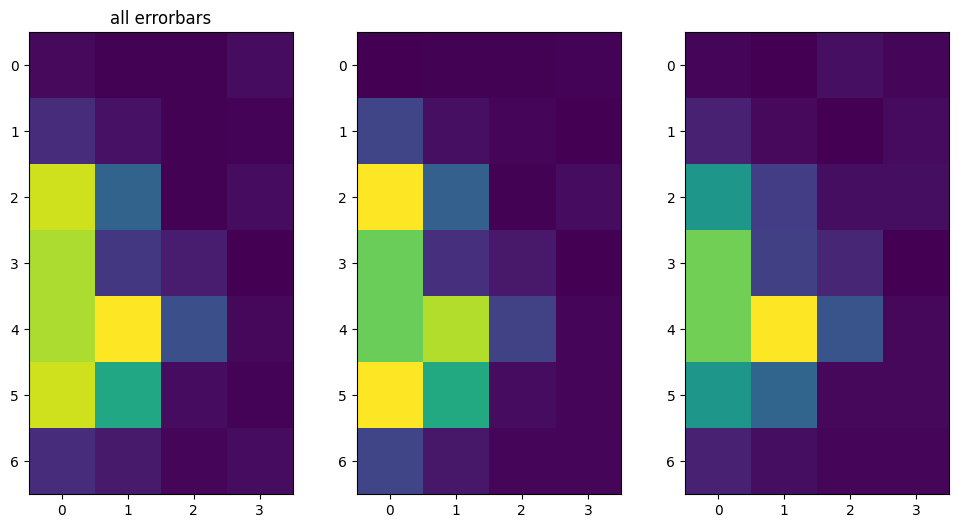

In [53]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3,figsize=(12, 6))

ax0.set_title('all errorbars')
ax0.imshow(torch.fft.rfft2(params_adam[0][0, 0, :, :]).abs().detach().cpu().numpy())
ax1.imshow(torch.fft.rfft2(params_adam[0][0, 1, :, :]).abs().detach().cpu().numpy())
ax2.imshow(torch.fft.rfft2(params_adam[0][0, 2, :, :]).abs().detach().cpu().numpy())

In [36]:
x = torch.rand(10, 10, dtype=torch.complex64)
fft2 = torch.fft.fft2(x)

In [ ]:
optimizer.